In [1]:
import requests
from __future__ import division, print_function
humpacks_url = "http://www.flukebook.org/listImages.jsp?genus=Megaptera&species=novaeangliae"
r = requests.get(humpacks_url)
print(r.status_code)

200


In [2]:
img_points_info = r.json()

In [3]:
img_points_info['mediaAssets'][0]

{u'catalogNumber': u'17120141841',
 u'individualID': u'Quasie',
 u'referenceImageURL': u'http://www.flukebook.org/caribwhale_data_dir/encounters/17120141841/extract17120141841.jpg',
 u'referencePoints': [{u'x': u'336.0936170212766',
   u'y': u'274.53191489361706'},
  {u'x': u'760.3702127659575', u'y': u'356.05957446808515'},
  {u'x': u'1382.6425531914895', u'y': u'269.5404255319149'}]}

In [4]:
from train_utils import dataset_loc
from os.path import exists, join
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
def downloadImage(img_url, cache=True):
    fn = img_url.split('/')[-1]
    stored_fn = join(imgs_dir, fn)
    if (not cache) or not exists(stored_fn):
        r = requests.get(img_url, stream=True)
        with open(stored_fn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return stored_fn

def displayPoints(imginfo, cache=True):
    # first download the image if it's not there
    imgfn = downloadImage(imginfo['referenceImageURL'], cache=cache)
    img = cv2.imread(imgfn)
    for pt in imginfo['referencePoints']:
        cv2.circle(img, (int(float(pt['x'])), int(float(pt['y']))), 10, (0,255,0), -1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


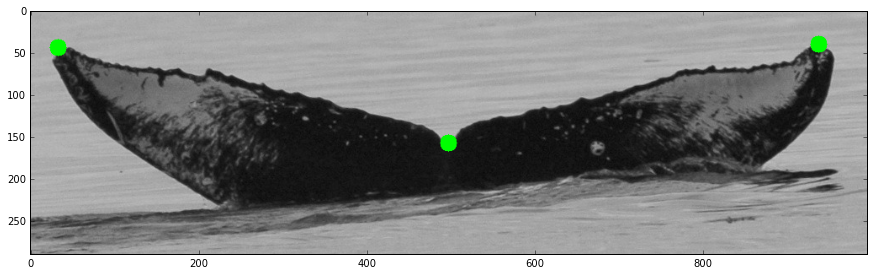

In [5]:
displayPoints(img_points_info['mediaAssets'][18])

In [6]:
for imginfo in img_points_info['mediaAssets']:
    if len(imginfo['referencePoints']) != 3:
        print(imginfo)

In [7]:
fb_curvatures = []
import utool as ut
for imginfo in ut.ProgressIter(img_points_info['mediaAssets'], lbl='Image'):
    img_url = imginfo['referenceImageURL']
    imgfn = downloadImage(img_url, cache=True)
    curvinfo = {'fn':imgfn.split('/')[-1],
                'id':imginfo['individualID'],}
    read_pts = lambda pts: {'x':int(float(pts['x'])), 'y':int(float(pts['y']))}
    img_points = sorted(map(read_pts, imginfo['referencePoints']), key=lambda x: x['x'])
    curvinfo['points'] = {'left':img_points[0], 'notch':img_points[1], 'right':img_points[2]}
    fb_curvatures.append(curvinfo)

Image    1/2178...  rate=23301.15 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    2/2178...  rate=3744.90 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    3/2178...  rate=4219.60 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    4/2178...  rate=4424.35 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    5/2178...  rate=4670.70 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    6/2178...  rate=4739.30 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    7/2178...  rate=4766.23 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    8/2178...  rate=4481.07 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image    9/2178...  rate=4717.98 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image   10/2178...  rate=4524.58 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image   11/2178...  rate=4788.00 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Image   12/2178...  rate=4782.54 Hz, etr=0:00:00, ellapsed=0:00:00, wall=14:54 EST
Ima

In [8]:
import cPickle as pickle
with open(join(dataset_loc, 'Flukes/Flukebook/flukebook_points_orig.pkl'), 'w') as f:
    pickle.dump(fb_curvatures, f)

In [9]:
from scipy.stats import norm
import numpy as np
def find_seam(img, start, end, center=None, n_neighbors=3, scale=1):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(n_neighbors % 2 == 1)
    #n_neighbors = img.shape[0]
    neighbor_range = range(-1*(n_neighbors // 2),1+(n_neighbors // 2))
    #weight_df = [norm.pdf(x, scale=scale) for x in neighbor_range]
    # start and end are x,y 
    # take the vertical gradients of the image
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # TODO maybe: blur before taking gradients to denoise
    # set the start point's vertical gradient to a very high value
    # for each row from start to end, the cost of each cell is the max
    # of the three neighbors to its left + its own cost
    # the max that is chosen is then stored for each pixel in a column so we can backtrack
    gradient_y_image[:,start[0]] = np.inf # make sure this is where the path starts
    gradient_y_image[start[1],start[0]] = 0 #np.max(gradient_y_image) + 1 # yeah I think this makes sense
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0 #np.max(gradient_y_image) + 1
    if center is not None:
        # force it to go through the center
        gradient_y_image[:,center[0]] = np.inf
        gradient_y_image[center[1],center[0]] = 0
    # the goal of the above is to make the path end at 'end', but that probably can't be guaranteed regardless
    cost = np.zeros(gradient_y_image.shape)
    back = np.zeros(gradient_y_image.shape,dtype=np.int32)
    get_cost = lambda row, col, i : np.inf if ((row+i < 0) or (row+i >= gradient_y_image.shape[0])) else cost[row+i,col-1] + gradient_y_image[row,col]
    for col in range(start[0],end[0]+1):
        # this is the slow part
        for row in range(gradient_y_image.shape[0]):
            #candidates = [((cost[cell+i, col-1]+gradient_y_image[cell,col]) if
            #              ((cell+i > 0) and (cell+i < gradient_y_image.shape[0])) else -np.inf) 
            #              for i in (-1,0,1)]
            candidates = [get_cost(row, col, i) for i in neighbor_range]
            best = np.argmin(candidates)
            #print(candidates)
            back[row, col] = best - (n_neighbors // 2)
            cost[row, col] = candidates[best]
    # backtrack the seam
    path = [] # we know that the path is from end to start so we don't need to store the x values
    curr_y = end[1]
    path_cost = 0
    # we know that the optimal path must end at the end point since otherwise its cost is -inf
    for col in range(start[0],end[0]+1)[::-1]:
        path_cost += cost[curr_y,col]
        path.append((col,curr_y)) 
        next_ = curr_y + back[curr_y,col]
        curr_y = next_
    #plt.imshow(cost)
    return path, path_cost, cost

import ctypes
lib = ctypes.cdll.LoadLibrary('../edge_match/icp_ctypes_cpp/ctypes_icp.so')
ndmat_f_type = np.ctypeslib.ndpointer(dtype=np.float32, ndim=2, flags='C_CONTIGUOUS')
ndmat_i_type = np.ctypeslib.ndpointer(dtype=np.int32, ndim=2, flags='C_CONTIGUOUS')

te_cpp = lib.find_trailing_edge
te_cpp.argtypes = [ndmat_f_type, ctypes.c_int, ctypes.c_int, # image and size info
                   ctypes.c_int, ctypes.c_int, ctypes.c_int, # startcol, endrow, endcol
                   ctypes.c_int, ndmat_i_type] # number of neighbors, output path

def find_trailing_edge_cpp(img, start, end, center, n_neighbors=5):
    # points are x,y
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(n_neighbors % 2 == 1)
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_32F,0,1,ksize=5)
    
    gradient_y_image[:, start[0]] = np.inf
    gradient_y_image[start[1],start[0]] = 0
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0
    
    gradient_y_image[:,center[0]] = np.inf
    gradient_y_image[center[1], center[0]] = 0
    
    outpath = np.zeros((end[0] - start[0], 2), dtype=np.int32)
    #cost_mat = np.zeros(gradient_y_image.shape, dtype=np.float32)
    cost = te_cpp(gradient_y_image, gradient_y_image.shape[0], gradient_y_image.shape[1],
                  start[0], end[1], end[0], n_neighbors, outpath)
    return outpath, cost



In [10]:
from collections import defaultdict
id_img_map = defaultdict(lambda: [])
for imginfo in img_points_info['mediaAssets']:
    id_img_map[imginfo['individualID']].append(imginfo['referenceImageURL'])
    
def make_dict_hist(dic):
    hist = defaultdict(lambda: 0)
    for id_ in dic:
        hist[len(dic[id_])] += 1
    return hist

id_img_hist = make_dict_hist(id_img_map)

In [11]:
len(id_img_map)

889

In [12]:
# before we do this, let's resize these images so that the X axis is always 960
# however it's important that we preserve the aspect ratio when doing this
# so what we should do is compute the aspect ratio of the image (x / y)
# we can set x arbitrarily (since that's the axis we're extracting / comparing edges over)

# if our ratio is x/y = r, we have x = y*r -- setting a new x to 960, we then get a new y as 960 / r
# let's test this out

def resize_x(new_x, img):
    # resize keeping aspect ratio
    try:
        ratio = img.shape[1] / img.shape[0]
        new_y = int(new_x / ratio)
    except ZeroDivisionError:
        print(ratio)
        print(img.shape)
        raise ZeroDivisionError
    return cv2.resize(img, (new_x, new_y), cv2.INTER_LANCZOS4)

def crop_image(img, left, right):
    # assume left / right are x, y
    return img[:,left[0]:right[0],:]

def resize_point(new_shape, old_shape, point):
    # assume point is x, y
    scale_x = new_shape[1] / old_shape[1]
    scale_y = new_shape[0] / old_shape[0]
    
    new_pt =  (int(point[0]*scale_x), int(point[1]*scale_y))
    return new_pt

def process_img_points(img, left, right, notch, crop=True):
    # assume left, right, notch are in x, y tuple format
    if crop:
        # first let's crop the image so that we center horizontally on the trailing edge
        cropped_img = crop_image(img, left, right)
        # adjust the points accordingly
        offset = left[0]
        left = (left[0] - (offset), left[1])
        right = (right[0] - (offset+1), right[1]) # to avoid the right point causing an index error
        notch = (notch[0] - offset, notch[1])
    else:
        cropped_img = img
    # then let's resize to a fixed width (say, 960), preserving the aspect ratio
    resized_img = resize_x(960, cropped_img)
    left = resize_point(resized_img.shape, cropped_img.shape, left)
    right = resize_point(resized_img.shape, cropped_img.shape, right)
    notch = resize_point(resized_img.shape, cropped_img.shape, notch)
    
    return resized_img, left, right, notch

xyconvert = lambda pt: (pt['x'], pt['y'])


(2499, 960, 3)
(0, 1522)
(959, 1627)
(467, 1686)
[[ 959 1627]
 [ 958 1629]
 [ 957 1631]
 ..., 
 [   3 1528]
 [   2 1526]
 [   1 1524]]
0


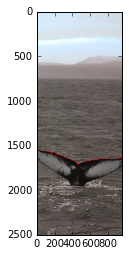

In [13]:
import random
test_curv = random.choice(fb_curvatures)
test_img = cv2.imread(join(imgs_dir, test_curv['fn']))
resized_img, left, right, notch = process_img_points(test_img, 
                                                     *[xyconvert(test_curv['points'][i]) 
                                                       for i in ['left','right','notch']])
print(resized_img.shape)
print(left)
print(right)
print(notch)

path, cost = find_trailing_edge_cpp(resized_img, left, right, notch, n_neighbors=5)
print(path)
print(cost)
for pt in path:
    cv2.circle(resized_img, tuple(pt), 2, (255,0,0), thickness=-1)
plt.imshow(resized_img)

In [14]:
troubled_imgs = []

for imginfo, uriinfo in ut.ProgressIter(zip(fb_curvatures, img_points_info['mediaAssets'])):
    imgfn = downloadImage(uriinfo['referenceImageURL'], cache=True)
    img = cv2.imread(join(imgs_dir, imgfn))
    
    if img.shape[:2] == (600,800):
        trouble_type = 1
        troubled_imgs.append((uriinfo['referenceImageURL'], trouble_type))
        continue
    try:
        resized_img, left, right, notch = process_img_points(img, xyconvert(imginfo['points']['left'])
                                                                , xyconvert(imginfo['points']['right'])
                                                                , xyconvert(imginfo['points']['notch']),
                                                            crop=False)

        path, cost = find_trailing_edge_cpp(resized_img, left, right, notch, n_neighbors=5)
    except (IndexError, ZeroDivisionError):
        print("Extraction failed on image %s" % imginfo['fn'])
        trouble_type = 2
        troubled_imgs.append((uriinfo['referenceImageURL'], trouble_type))
        continue
    #print(path.shape)
    imginfo['edge'] = path


lbl    1/2178...  rate=31.81 Hz, etr=0:01:08, ellapsed=0:00:00, wall=14:54 EST
lbl    2/2178...  rate=36.32 Hz, etr=0:00:59, ellapsed=0:00:00, wall=14:54 EST
lbl    3/2178...  rate=32.72 Hz, etr=0:01:06, ellapsed=0:00:00, wall=14:54 EST
lbl    4/2178...  rate=37.06 Hz, etr=0:00:58, ellapsed=0:00:00, wall=14:54 EST
lbl    5/2178...  rate=43.60 Hz, etr=0:00:49, ellapsed=0:00:00, wall=14:54 EST
lbl    6/2178...  rate=54.38 Hz, etr=0:00:39, ellapsed=0:00:00, wall=14:54 EST
lbl    7/2178...  rate=50.48 Hz, etr=0:00:43, ellapsed=0:00:00, wall=14:54 EST
lbl    8/2178...  rate=43.46 Hz, etr=0:00:49, ellapsed=0:00:00, wall=14:54 EST
lbl    9/2178...  rate=79.72 Hz, etr=0:00:27, ellapsed=0:00:00, wall=14:54 EST
lbl   10/2178...  rate=75.53 Hz, etr=0:00:28, ellapsed=0:00:00, wall=14:54 EST
lbl   11/2178...  rate=77.39 Hz, etr=0:00:28, ellapsed=0:00:00, wall=14:54 EST
lbl   12/2178...  rate=73.89 Hz, etr=0:00:29, ellapsed=0:00:00, wall=14:54 EST
lbl   13/2178...  rate=85.40 Hz, etr=0:00:25, ellaps

In [15]:
import json
with open(join(dataset_loc, 'flukebook_bad.json'), 'w') as f:
    json.dump(troubled_imgs, f)

In [16]:
print(fb_curvatures[-1]['edge'])

[[923  66]
 [922  67]
 [921  67]
 ..., 
 [ 30  27]
 [ 29  27]
 [ 28  28]]


In [17]:
filter(lambda x: x[0].split('/')[-1] == 'extractdc4eafd8-b97c-4a56-81ee-f5921f34e84b.jpg', troubled_imgs)

[(u'http://www.flukebook.org/caribwhale_data_dir/encounters/d/c/dc4eafd8-b97c-4a56-81ee-f5921f34e84b/extractdc4eafd8-b97c-4a56-81ee-f5921f34e84b.jpg',
  1)]

(0, 31)
(959, 152)
(476, 354)


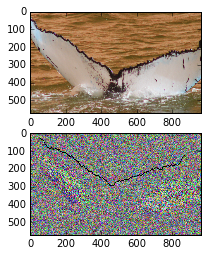

In [18]:
import random
def displayEdge(imginfo):
    img = cv2.imread(join(imgs_dir, imginfo['fn']))
    resized_img, left, right, notch = process_img_points(img, xyconvert(imginfo['points']['left'])
                                                        , xyconvert(imginfo['points']['right'])
                                                        , xyconvert(imginfo['points']['notch']))
    gradient_y_img = 1*cv2.Sobel(resized_img,cv2.CV_32F,0,1,ksize=5)
    print(left)
    print(right)
    print(notch)
    for edgePoint in imginfo['edge']:
        cv2.circle(gradient_y_img, tuple(edgePoint), 2, (255,0,0), thickness=-1)
    plt.figure(figsize=(15,15))
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(resized_img)
    ax[1].imshow(gradient_y_img)

displayEdge(random.choice(fb_curvatures))

In [19]:
curvatures_assigned = list(filter(lambda x: x['id'] != 'Unassigned', fb_curvatures))
curvatures_good = list(filter(lambda x: 'edge' in x, curvatures_assigned))
curvatures_mult = filter(lambda x: len(
            filter(lambda y: y not in set(zip(*troubled_imgs)[0]), id_img_map[x['id']])) > 1, curvatures_good)

In [20]:
print(len(curvatures_good))

1404


In [21]:
print(len(curvatures_mult))

with open(join(dataset_loc, "Flukes/Flukebook/fb_edges_mult_resize.pkl"), 'w') as f:
    pickle.dump(curvatures_mult, f)

972


In [22]:
max([len(i['edge']) for i in curvatures_mult])

953

In [23]:
id_localfn_map = defaultdict(lambda: [])
for c in curvatures_good:
    id_localfn_map[c['id']].append(c['fn'])

In [24]:
print(min([len(x) for x in id_localfn_map.values()]))

1


In [25]:
# organize images into named folders
# turn into named folder format for analysis with IBEIS
# this disregards any notions of train/val/test
from shutil import rmtree, copy2
from os import mkdir

def make_named_folders(id_fn_map, savedir, existing_dir):
    working_dir = join(join(dataset_loc,"Flukes/Flukebook/named_images"),savedir)
    if not exists(working_dir):
        mkdir(working_dir)
    else:
        print("Warning: Going to delete %s to prevent duplicates, continue? y/n" % savedir)
        confirm = raw_input()
        if confirm != 'y':
            return
        else:
            print("Deleting %s" % working_dir)
            rmtree(working_dir)
            mkdir(working_dir)
            
    #patch_names = ['notch','left','right']
    for indv_id in id_fn_map:
        if indv_id == 'Unassigned':
            continue
        for fn in id_fn_map[indv_id]:
            indv_patch_folder = join(working_dir,'%s' % (indv_id))
            if not exists(indv_patch_folder):
                mkdir(indv_patch_folder)
            copy2(join(existing_dir, fn), join(indv_patch_folder, fn))
            #cv2.imwrite(join(indv_patch_folder,'%d.jpg' % imgnum),patches[pname]) 
            
make_named_folders(id_localfn_map, '20160128', imgs_dir)

y
Deleting /home/zach/data/Flukes/Flukebook/named_images/20160128


In [26]:
fluke_image_points = {}
for c in curvatures_good:
    fluke_image_points[c['fn']] = {p:np.array(xyconvert(c['points'][p])) for p in c['points']}

In [27]:
with open(join(dataset_loc, 'IBEIS/humpbacks_fb/fluke_image_points.pkl'), 'w') as f:
    pickle.dump(fluke_image_points, f)